In [1]:
import os, shutil

In [2]:
base_dir = '/home/skhatter/rooftop_damage_data/'
train_dir = '/home/skhatter/rooftop_damage_data/train'
valid_dir = '/home/skhatter/rooftop_damage_data/val'
test_dir = '/home/skhatter/rooftop_damage_data/test'


train_dam_dir = '/home/skhatter/rooftop_damage_data/train/wind_damaged'
train_undam_dir = '/home/skhatter/rooftop_damage_data/train/undamaged'
train_obj_dir = '/home/skhatter/rooftop_damage_data/train/object' 
train_notroof_dir = '/home/skhatter/rooftop_damage_data/train/not_roof'

valid_dam_dir = '/home/skhatter/rooftop_damage_data/val/wind_damaged'
valid_undam_dir = '/home/skhatter/rooftop_damage_data/val/undamaged'
valid_obj_dir = '/home/skhatter/rooftop_damage_data/val/object'
valid_notroof_dir = '/home/skhatter/rooftop_damage_data/val/not_roof'

In [3]:
print('Total training wind-damaged images', len(os.listdir(train_dam_dir)))
print('Total training undamaged images', len(os.listdir(train_undam_dir)))
print('Total training object images', len(os.listdir(train_obj_dir)))
print('Total training not-roof images', len(os.listdir(train_notroof_dir)))


print('Total validation wind-damaged images', len(os.listdir(valid_dam_dir)))
print('Total validation undamaged images', len(os.listdir(valid_undam_dir)))
print('Total validation object images', len(os.listdir(valid_obj_dir)))
print('Total validation notroof images', len(os.listdir(valid_notroof_dir)))


print('Total test damaged images', len(os.listdir(test_dir)))

Total training wind-damaged images 27914
Total training undamaged images 38020
Total training object images 3668
Total training not-roof images 34536
Total validation wind-damaged images 99
Total validation undamaged images 163
Total validation object images 9
Total validation notroof images 173
Total test damaged images 10


In [4]:
from keras import layers
from keras import models
from keras.applications import ResNet50

Using TensorFlow backend.


In [5]:
conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape=(512, 512, 3))
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 256, 256, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 256, 256, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 256, 256, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='sigmoid'))

In [7]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'res5c_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 25,686,148
Trainable params: 6,564,100
Non-trainable params: 19,122,048
_________________________________________________________________


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255)


train_generator = datagen.flow_from_directory(train_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'categorical')


validation_generator = datagen.flow_from_directory(valid_dir,
                                             target_size = (512, 512), 
                                              batch_size = 20,
                                              class_mode = 'categorical')
                                              

Found 104138 images belonging to 4 classes.
Found 444 images belonging to 4 classes.


In [10]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=1000,
                    epochs=5,  
                    validation_data=validation_generator,
                   validation_steps = 500)

Epoch 1/5
1000/1000 [==============================] - 820s - loss: 0.1719 - categorical_accuracy: 0.9423 - val_loss: 0.8571 - val_categorical_accuracy: 0.7868
Epoch 2/5
1000/1000 [==============================] - 814s - loss: 0.0799 - categorical_accuracy: 0.9780 - val_loss: 0.0304 - val_categorical_accuracy: 0.9910
Epoch 3/5
1000/1000 [==============================] - 815s - loss: 0.0527 - categorical_accuracy: 0.9857 - val_loss: 0.1808 - val_categorical_accuracy: 0.9819
Epoch 4/5
1000/1000 [==============================] - 816s - loss: 0.0553 - categorical_accuracy: 0.9859 - val_loss: 0.1214 - val_categorical_accuracy: 0.9665
Epoch 5/5
1000/1000 [==============================] - 815s - loss: 0.0468 - categorical_accuracy: 0.9883 - val_loss: 0.2123 - val_categorical_accuracy: 0.9666


In [11]:
history_dict = history.history
print(history_dict.keys())

model.save('resnet_four_classes_sigmoid.h5')

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


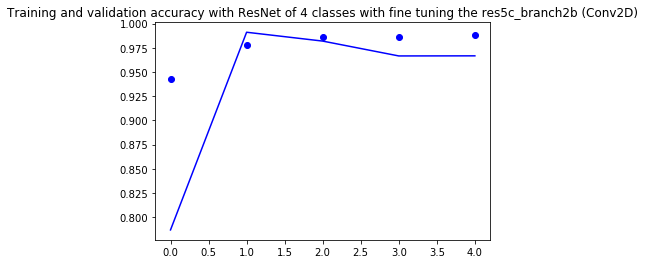

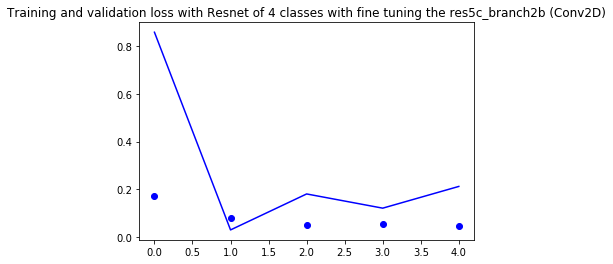

In [12]:
#Displaying curves of loss and accuracy during training 

import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo')#dots
plt.plot(epochs, val_acc, 'b')#line segments
plt.title('Training and validation accuracy with ResNet of 4 classes with fine tuning the res5c_branch2b (Conv2D)')
plt.figure()

plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss with Resnet of 4 classes with fine tuning the res5c_branch2b (Conv2D)')
plt.show()